In [2]:
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
from sklearn.cluster import KMeans
import random

from lib.baseline import *
from lib.baycon import execute

from lib.CF_De.cfde import CF_Descent
from lib.cf_a.cfae import CF_Ascent
from dataclasses import dataclass
from lib.eval.generator import run
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cross testing of methods

In [3]:
#X, true_y = load_wine(return_X_y=True)
X, true_y = load_breast_cancer(return_X_y=True)
nc = 3
km = KMeans(n_clusters=nc)
y = km.fit_predict(X)
centers = km.cluster_centers_
print(centers)

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: float
    instance_label: float

n = 1
cfs = []
for i in range(n):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)
    
    cfs.append(CounterfactualData([], index, float(target), label))

[[1.85285124e+01 2.15790909e+01 1.22283471e+02 1.07481240e+03
  1.00261240e-01 1.41826612e-01 1.61977355e-01 9.20814050e-02
  1.91676860e-01 6.06204959e-02 6.49142149e-01 1.21641983e+00
  4.56371901e+00 7.68210744e+01 6.61174380e-03 3.13276529e-02
  4.16239669e-02 1.55374463e-02 2.01668595e-02 3.96714050e-03
  2.23823967e+01 2.87747107e+01 1.49064463e+02 1.54647107e+03
  1.39227107e-01 3.46117851e-01 4.31357851e-01 1.82432645e-01
  3.15462810e-01 8.62268595e-02]
 [1.24751725e+01 1.84901166e+01 8.05764103e+01 4.88859207e+02
  9.49148252e-02 9.07750117e-02 6.15064119e-02 3.29390303e-02
  1.77986946e-01 6.35734266e-02 3.01556410e-01 1.21532704e+00
  2.13489441e+00 2.33540979e+01 7.15913287e-03 2.33434848e-02
  2.84384956e-02 1.05576713e-02 2.06707646e-02 3.74588648e-03
  1.39398578e+01 2.45990443e+01 9.12271096e+01 6.09272261e+02
  1.30029254e-01 2.22372145e-01 2.16939503e-01 9.04745711e-02
  2.82924942e-01 8.33942191e-02]
 [2.34015789e+01 2.27621053e+01 1.56147368e+02 1.72942105e+03
  1.

## Baseline

In [4]:
from lib.baseline import baseline_explainer
from lib.baycon import baycon_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = baycon_explainer
baseline_cfs = []
for cf in cfs:
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

Done training classifier. Score: 1.0
--- Executing... Initial Instance: 271 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (778) CFs (0)
Re-training surrogate model with data size: 778
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (7) Unique overall (7)
Generated random instances: (3705)
Predicted top: 20 Counterfactuals: 4
Found new best [2.0326112e+01 1.7999360e+01 1.3031052e+02 3.8800000e+02 9.8340000e-02
 7.6080000e-02 3.2650000e-02 2.7550000e-02 1.7690000e-01 6.2700000e-02
 1.9040000e-01 1.0365532e+00 1.1640000e+00 5.0131200e+01 5.8199700e-03
 9.4834440e-03 1.2820000e-02 8.8490000e-03 1.6920000e-02 2.8170000e-03
 2.1450520e+01 1.9726000e+01 1.6501656e+02 7.7212840e+02 1.3580000e-01
 1.2323100e-01 1.2750000e-01 1.8711792e-01 2.7330000e-01 7.1772120e-02], with fitness score 0.4579 (X 0.85851 Y 1.0 F 0.53333), oversampling

## Baycon

In [5]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['classic_baycon', 'kmeans', 'model_agnostic']
run_mode = modes[2]


if run_mode == modes[0]:
    model = RandomForestClassifier()
elif run_mode == modes[1]:
    model = KMeans(n_clusters=3)
elif run_mode == modes[2]:
    model = KMeans(n_clusters=3)
    # model = SpectralClustering(n_clusters=3)
else:
    raise("Invalid baycon mode")
model.fit(X, y)
pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(model.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="classification", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[2]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, model, t, point_idx)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

--- Executing... Initial Instance: 271 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (773) CFs (186)
Re-training surrogate model with data size: 773
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (26) Unique overall (26)
Generated random instances: (1618)
Predicted top: 20 Counterfactuals: 20
Found new best [1.9000496e+01 2.3202300e+01 1.0244064e+02 7.8585520e+02 9.2724560e-02
 7.6080000e-02 1.9042992e-01 2.7550000e-02 1.7690000e-01 6.2700000e-02
 1.9040000e-01 1.3374880e+00 5.7906240e+00 3.5509600e+01 6.4720000e-03
 2.1074320e-02 1.2820000e-02 8.8490000e-03 1.6028700e-02 2.8170000e-03
 2.4169600e+01 2.7813660e+01 7.8270000e+01 4.5750000e+02 1.3580000e-01
 1.8238188e-01 1.2750000e-01 8.7500000e-02 2.7330000e-01 8.2025280e-02], with fitness score 0.2526 (X 0.84193 Y 0.6 F 0.5), oversampling
Known alternatives: 793
Best instan

## CFDE

In [6]:
cfde_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x1, cf1, h1 = CF_Descent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        temp_cfs.append(cf1)
    cfde_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))    

cfde_cfs

[CounterfactualData(cf=[array([1.12900000e+01, 1.30400000e+01, 7.22300000e+01, 3.88000000e+02,
        1.00261240e-01, 1.41826612e-01, 1.61977355e-01, 9.20814050e-02,
        1.91676860e-01, 6.06204959e-02, 6.49142149e-01, 5.29300000e-01,
        1.16400000e+00, 1.31700000e+01, 6.61174380e-03, 3.13276529e-02,
        4.16239669e-02, 1.55374463e-02, 2.01668595e-02, 3.96714050e-03,
        1.23200000e+01, 1.61800000e+01, 7.82700000e+01, 1.33034872e+03,
        1.39227107e-01, 3.46117851e-01, 4.31357851e-01, 1.82432645e-01,
        3.15462810e-01, 8.62268595e-02]), array([1.12900000e+01, 1.30400000e+01, 7.22300000e+01, 3.88000000e+02,
        1.00261240e-01, 1.41826612e-01, 1.61977355e-01, 9.20814050e-02,
        1.91676860e-01, 6.06204959e-02, 6.49142149e-01, 5.29300000e-01,
        1.16400000e+00, 1.31700000e+01, 6.61174380e-03, 3.13276529e-02,
        4.16239669e-02, 1.55374463e-02, 2.01668595e-02, 3.96714050e-03,
        1.23200000e+01, 1.61800000e+01, 7.82700000e+01, 1.33197755e+03,


## CFAE

In [7]:
cfae_cfs = []
amount = 20
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        temp_cfs.append(cf2)
    cfae_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

cfae_cfs

[CounterfactualData(cf=[array([1.12900000e+01, 1.30400000e+01, 7.22300000e+01, 6.88218184e+02,
        9.83400000e-02, 7.60800000e-02, 3.26500000e-02, 2.75500000e-02,
        1.76900000e-01, 6.27000000e-02, 1.90400000e-01, 5.29300000e-01,
        1.16400000e+00, 1.31700000e+01, 6.47200000e-03, 1.12200000e-02,
        1.28200000e-02, 8.84900000e-03, 1.69200000e-02, 2.81700000e-03,
        1.23200000e+01, 1.61800000e+01, 7.82700000e+01, 1.10641704e+03,
        1.35800000e-01, 1.50700000e-01, 1.27500000e-01, 8.75000000e-02,
        2.73300000e-01, 8.02200000e-02]), array([1.12900000e+01, 1.30400000e+01, 7.22300000e+01, 7.31582273e+02,
        9.83400000e-02, 7.60800000e-02, 3.26500000e-02, 2.75500000e-02,
        1.76900000e-01, 6.27000000e-02, 1.90400000e-01, 5.29300000e-01,
        1.16400000e+00, 1.31700000e+01, 6.47200000e-03, 1.12200000e-02,
        1.28200000e-02, 8.84900000e-03, 1.69200000e-02, 2.81700000e-03,
        1.23200000e+01, 1.61800000e+01, 7.82700000e+01, 1.11024714e+03,


## Testing

In [8]:
baseLine = {
    "name": "Baseline",
    "counterfactuals": baseline_cfs
}
Baycon = {
    "name": "Baycon",
    "counterfactuals": baycon_cfs
}
cfde = {
    "name": "CF-DE",
    "counterfactuals": cfde_cfs
}
cfae = {
    "name": "CF-AE",
    "counterfactuals": cfae_cfs
}

methods = [baseLine, Baycon, cfde, cfae]
results, names = run(methods, centers, X, y)

print("Diversity metric - ")
print("Baseline: " + str(results["Baseline"][0][4]))
print("Baycon: " + str(results["Baycon"][0][4]))
print("CF-DE: " + str(results["CF-DE"][0][4]))
print("CF-AE: " + str(results["CF-AE"][0][4]))

Diversity metric - 
Baseline: 3.8480888992974293e-88
Baycon: -6.5706e-320
CF-DE: -4.6205041300534506e-18
CF-AE: 0.7334628913738265


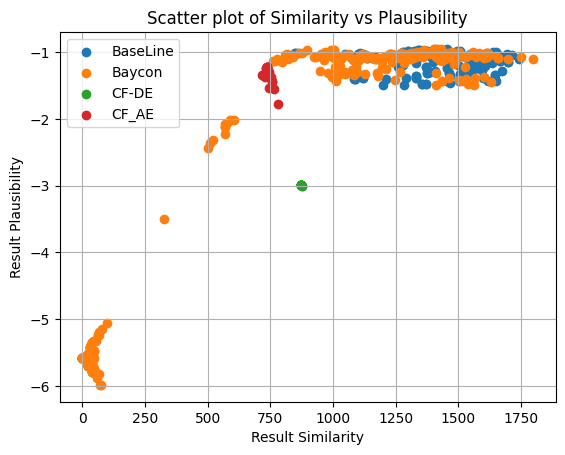

In [9]:
def plot(f1, f2, results_list, names):
    method_names = ["BaseLine", "Baycon", "CF-DE", "CF_AE"]
    for idx, results in enumerate(results_list):
        result_x = [row[f1] for row in results]
        result_y = [row[f2] for row in results]

        plt.scatter(result_x, result_y, label=f"{method_names[idx]}")

    # Adding title and labels
    plt.title(f"Scatter plot of {names[f1]} vs {names[f2]}")
    plt.xlabel(f"Result {names[f1]}")
    plt.ylabel(f"Result {names[f2]}")
    plt.grid(True)

    # Show the legend to distinguish between different datasets
    plt.legend()
    plt.show()

plot(0,2, [results["Baseline"], results["Baycon"], results["CF-DE"], results["CF-AE"]], names)

<Axes: >

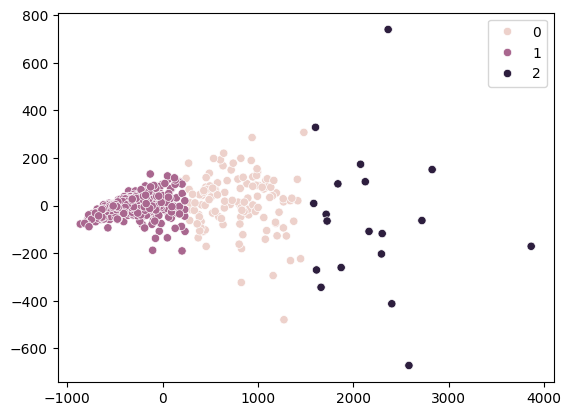

In [10]:
pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

<Axes: title={'center': 'Instance from cluster 1 into 0'}>

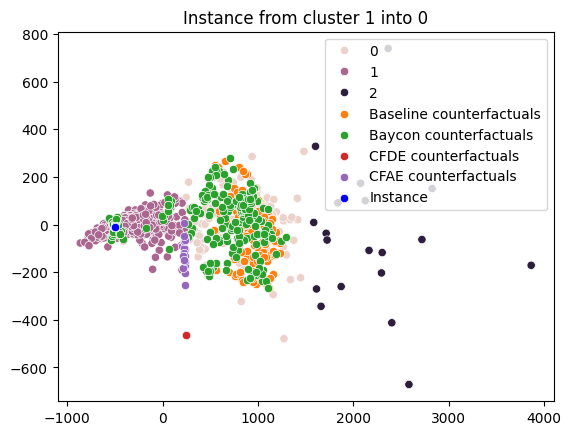

In [11]:
cf_n = 0
baseline_embed = [pca.transform(v.cf) for v in baseline_cfs][cf_n]
baycon_embed = [pca.transform(v.cf) for v in baycon_cfs][cf_n]
cfde_embed = [pca.transform(v.cf) for v in cfde_cfs][cf_n]
cfae_embed = [pca.transform(v.cf) for v in cfae_cfs][cf_n]
instance_embedded = pca.transform(X[[baseline_cfs[cf_n].instance]])

ins_c = baseline_cfs[cf_n].instance_label
target_c = baseline_cfs[cf_n].target

plt.title(f"Instance from cluster {ins_c} into {int(target_c)}")
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)
sns.scatterplot(x=baseline_embed[:,0], y=baseline_embed[:,1], label="Baseline counterfactuals")
sns.scatterplot(x=baycon_embed[:,0], y=baycon_embed[:,1], label="Baycon counterfactuals")
sns.scatterplot(x=cfde_embed[:,0], y=cfde_embed[:,1], label="CFDE counterfactuals")
sns.scatterplot(x=cfae_embed[:,0], y=cfae_embed[:,1], label="CFAE counterfactuals")
sns.scatterplot(x=instance_embedded[:,0], y=instance_embedded[:,1], label="Instance", color="blue")


## Running time

In [12]:
import time
baseline_rt = 0.0
baycon_rt = 0.0
cfde_rt = 0.0
cfae_rt = 0.0

it_rt = 5
for _ in range(it_rt):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)

    timestamp = time.time()
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, index, target_cluster=int(target))
    baseline_rt += time.time() - timestamp

    timestamp = time.time()
    t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))
    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, model, t, index)
    baycon_rt += time.time() - timestamp

    timestamp = time.time()
    x1, cf1, h1 = CF_Descent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20)
    cfde_rt += time.time() - timestamp

    timestamp = time.time()
    x2, cf2, h2 = CF_Ascent(X=X,y=y,target=target,centers=centers,instance_index=index, stop_count=20, center_mode=False)
    cfae_rt += time.time() - timestamp

baseline_rt /= it_rt
baycon_rt /= it_rt
cfde_rt /= it_rt
cfae_rt /= it_rt

print(f"Baseline: {baseline_rt}")
print(f"Baycon:   {baycon_rt}")
print(f"CFDE:     {cfde_rt}")
print(f"CFAE:     {cfae_rt}")


Done training classifier. Score: 1.0
--- Executing... Initial Instance: 103 Target: 2 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (772) CFs (0)
Re-training surrogate model with data size: 772
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (6) Unique overall (6)
Generated random instances: (3742)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 792
Best instance score 0.0000 (X 0.99514 Y 0.0 F 0.96667), found on epoch: 0
Re-training surrogate model with data size: 792
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (267) Unique overall (273)
Generated random instances: (3708)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 812
Best instance score 0.0000 (X 0.99514 Y 0.0 F 0.96667), found on epoch: 0
Re-training surrogate model with data size: 812
--- epoch 3 ----
Generating neig

KeyboardInterrupt: 

## RD-CFAE vs CFAE
*rd is random-direction

In [ ]:
n = 1
cfs_div = []
for i in range(n):
    index = random.randint(0, len(X)-1)
    label = y[index]
    target = label
    while target == label:
        target = random.randint(0, nc-1)
    
    cfs_div.append(CounterfactualData([], index, float(target), label))

amount = 70

cfae_cfs_div = []
for cf in cfs_div:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        temp_cfs.append(cf2)
    cfae_cfs_div.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

rd_cfae_cfs_div = []
for cf in cfs_div:
    temp_cfs = []
    for i in range(amount):
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        temp_cfs.append(cf2)
    rd_cfae_cfs_div.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

<Axes: title={'center': 'Instance from cluster 1 into 0'}>

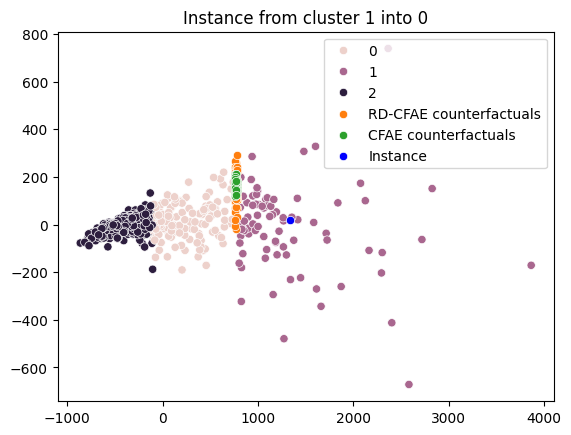

In [ ]:
cf_n = 0
cfae_embed = [pca.transform(v.cf) for v in cfae_cfs_div][cf_n]
rd_cfae_embed = [pca.transform(v.cf) for v in rd_cfae_cfs_div][cf_n]
instance_embedded = pca.transform(X[[cfae_cfs_div[cf_n].instance]])

ins_c = cfae_cfs_div[cf_n].instance_label
target_c = cfae_cfs_div[cf_n].target

plt.title(f"Instance from cluster {ins_c} into {int(target_c)}")
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)
sns.scatterplot(x=rd_cfae_embed[:,0], y=rd_cfae_embed[:,1], label="RD-CFAE counterfactuals")
sns.scatterplot(x=cfae_embed[:,0], y=cfae_embed[:,1], label="CFAE counterfactuals")
sns.scatterplot(x=instance_embedded[:,0], y=instance_embedded[:,1], label="Instance", color="blue")